# Fit CoFactor model

In [1]:
import itertools
import glob
import os
import sys
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from scipy import sparse
import seaborn as sns
sns.set(context="paper", font_scale=1.5, rc={"lines.linewidth": 2}, font='DejaVu Serif')

In [2]:
import cofacto
import rec_eval

### Construct the positive pairwise mutual information (PPMI) matrix

Change this to wherever you saved the pre-processed data following [this notebook](./preprocess_ML20M.ipynb).

In [3]:
DATA_DIR = '/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/data/pro'

In [4]:
unique_uid = list()
with open(os.path.join(DATA_DIR, 'unique_uid.txt'), 'r') as f:
    for line in f:
        unique_uid.append(line.strip())
    
unique_sid = list()
with open(os.path.join(DATA_DIR, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

In [5]:
unique_sid

['1-1-12-12',
 '1-1-13-13',
 '1-1-14-14',
 '1-1-18-10',
 '1-1-18-16',
 '1-1-18-17',
 '1-1-18-18',
 '1-1-18-20',
 '1-1-18-32',
 '1-1-18-33',
 '1-1-19-19',
 '1-1-2-2',
 '1-1-3-3',
 '1-1-30-30',
 '1-1-32-24',
 '1-1-4-4',
 '1-1-5-31',
 '1-1-6-5',
 '1-1-7-7',
 '1-1-8-6',
 '1-1-9-9',
 '1-11-12-12',
 '1-11-13-11',
 '1-11-13-13',
 '1-11-13-14',
 '1-11-13-15',
 '1-11-3-1',
 '1-11-3-2',
 '1-11-3-27',
 '1-11-3-28',
 '1-11-3-3',
 '1-11-3-9',
 '1-11-4-30',
 '1-11-5-16',
 '1-11-5-24',
 '1-11-5-4',
 '1-11-5-5',
 '1-11-6-6',
 '1-11-8-10',
 '1-11-8-22',
 '1-11-8-8',
 '1-12-1-10',
 '1-12-1-11',
 '1-12-1-12',
 '1-12-1-14',
 '1-12-1-9',
 '1-12-17-17',
 '1-12-17-2',
 '1-12-17-4',
 '1-12-17-7',
 '1-12-17-8',
 '1-12-18-18',
 '1-12-2-41',
 '1-12-3-13',
 '1-12-3-15',
 '1-12-3-24',
 '1-12-3-25',
 '1-12-3-3',
 '1-12-3-40',
 '1-12-4-42',
 '1-12-5-5',
 '1-15-1-1',
 '1-15-10-10',
 '1-15-11-2',
 '1-15-11-4',
 '1-15-12-12',
 '1-15-5-5',
 '1-15-8-8',
 '1-15-9-9',
 '1-17-1-1',
 '1-17-1-3',
 '1-17-1-30',
 '1-17-1-31',
 

In [6]:
n_items = len(unique_sid)
n_users = len(unique_uid)

print(n_users, n_items)

13107 1957


In [7]:
raw_train_data=pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

In [8]:
raw_test_data=pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

In [9]:
raw_vad_data=pd.read_csv(os.path.join(DATA_DIR, 'validation.csv'))

In [10]:
raw_total_data = [raw_train_data,raw_test_data,raw_vad_data]

In [11]:
raw_total_data=pd.concat(raw_total_data)

In [12]:
raw_total_data

,timestamp,uid,sid
0,1517596500,11278,371
1,1517599020,12117,1248
2,1517599080,11516,1439
3,1517599140,11819,124
4,1517599140,11819,1243
5,1517599140,11819,829
6,1517599860,4835,242
7,1517601600,606,1278
8,1517604360,8699,1223
9,1517604360,8699,1223


In [13]:
raw_total_data['userstamp']=raw_total_data['timestamp'].map(str)+'-'+raw_total_data['uid'].map(str)

In [14]:
raw_total_data.head()

,timestamp,uid,sid,userstamp
0,1517596500,11278,371,1517596500-11278
1,1517599020,12117,1248,1517599020-12117
2,1517599080,11516,1439,1517599080-11516
3,1517599140,11819,124,1517599140-11819
4,1517599140,11819,1243,1517599140-11819


In [15]:
unique_userstamp=np.unique(raw_total_data['userstamp'])

In [16]:
unique_userstamp=pd.DataFrame(unique_userstamp)

In [17]:
unique_userstamp['idx']=unique_userstamp.index

In [18]:
unique_userstamp.columns=['userstamp', 'idx']

In [19]:
unique_userstamp.head()

,userstamp,idx
0,1517596500-11278,0
1,1517599020-12117,1
2,1517599080-11516,2
3,1517599140-11819,3
4,1517599860-4835,4


In [20]:
raw_total_data=pd.merge(raw_total_data,unique_userstamp,on='userstamp')


In [21]:
raw_total_data.head()

,timestamp,uid,sid,userstamp,idx
0,1517596500,11278,371,1517596500-11278,0
1,1517599020,12117,1248,1517599020-12117,1
2,1517599080,11516,1439,1517599080-11516,2
3,1517599140,11819,124,1517599140-11819,3
4,1517599140,11819,1243,1517599140-11819,3


In [22]:
ref = {enumerate(raw_total_data.idx):enumerate(raw_total_data.uid)}

In [23]:
raw_total_data

,timestamp,uid,sid,userstamp,idx
0,1517596500,11278,371,1517596500-11278,0
1,1517599020,12117,1248,1517599020-12117,1
2,1517599080,11516,1439,1517599080-11516,2
3,1517599140,11819,124,1517599140-11819,3
4,1517599140,11819,1243,1517599140-11819,3
5,1517599140,11819,829,1517599140-11819,3
6,1517599860,4835,242,1517599860-4835,4
7,1517601600,606,1278,1517601600-606,5
8,1517604360,8699,1223,1517604360-8699,6
9,1517604360,8699,1223,1517604360-8699,6


In [24]:
def get_uid_new(df_uid_sid):
    
    return pd.merge(raw_total_data,df_uid_sid,on=['uid','sid'])

In [25]:
raw_total_data.to_csv('/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/data/pro/Masking/Trans_Based/new_data.csv')

In [26]:
n_userstamp=max(raw_total_data.idx)+1

In [27]:
n_userstamp

291302

In [28]:
n_users

13107

In [29]:
n_userstamp

291302

In [30]:
n_items

1957

In [31]:
DATA_DIR = '/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/data/pro/Masking/Trans_Based/'

In [32]:
def load_data(csv_file,n_users,n_items,n_userstamp):
    tp = pd.read_csv(csv_file)
    timestamps, rows, cols,idx = np.array(tp['timestamp']), np.array(tp['uid']), np.array(tp['sid']),np.array(tp['idx'])
    seq = sparse.csr_matrix((np.ones_like(idx), (idx, cols)), dtype=np.int16, shape=(n_userstamp,n_items))
    data = sparse.csr_matrix((np.ones_like(rows), (rows, cols)), dtype=np.int16, shape=(n_users,n_items))
    return data, seq

In [33]:
total_data, total_ts_data = load_data(os.path.join(DATA_DIR, 'new_data.csv'),n_users,n_items,n_userstamp)

In [34]:
total_data.shape

(13107, 1957)

In [35]:
total_ts_data.shape

(291302, 1957)

In [36]:
training_set = total_data.copy()

In [37]:
nonzero_inds = training_set.nonzero()

In [38]:
nonzero_inds

(array([    0,     0,     0, ..., 13106, 13106, 13106], dtype=int32),
 array([  11,   26,  164, ..., 1906, 1914, 1922], dtype=int32))

In [39]:
nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1]))


In [40]:
nonzero_pairs

[(0, 11),
 (0, 26),
 (0, 164),
 (0, 173),
 (0, 211),
 (0, 215),
 (0, 216),
 (0, 217),
 (0, 231),
 (0, 390),
 (0, 416),
 (0, 420),
 (0, 601),
 (0, 1040),
 (0, 1168),
 (0, 1202),
 (0, 1548),
 (0, 1654),
 (0, 1856),
 (0, 1876),
 (1, 0),
 (1, 66),
 (1, 71),
 (1, 94),
 (1, 124),
 (1, 154),
 (1, 173),
 (1, 453),
 (1, 499),
 (1, 553),
 (1, 555),
 (1, 557),
 (1, 562),
 (1, 567),
 (1, 568),
 (1, 590),
 (1, 669),
 (1, 901),
 (1, 1046),
 (1, 1052),
 (1, 1083),
 (1, 1188),
 (1, 1207),
 (1, 1434),
 (1, 1439),
 (2, 19),
 (2, 26),
 (2, 27),
 (2, 28),
 (2, 157),
 (2, 182),
 (2, 244),
 (2, 380),
 (2, 387),
 (2, 390),
 (2, 399),
 (2, 412),
 (2, 573),
 (2, 594),
 (2, 742),
 (2, 829),
 (2, 1230),
 (2, 1366),
 (2, 1635),
 (2, 1666),
 (2, 1709),
 (2, 1712),
 (2, 1770),
 (2, 1772),
 (2, 1815),
 (2, 1832),
 (2, 1855),
 (2, 1856),
 (2, 1922),
 (3, 66),
 (3, 118),
 (3, 128),
 (3, 367),
 (3, 412),
 (3, 427),
 (3, 499),
 (3, 676),
 (3, 688),
 (3, 690),
 (3, 701),
 (3, 827),
 (3, 829),
 (3, 834),
 (3, 1026),
 (3, 

In [41]:
np.random.seed(123)

In [42]:
num_samples = int(np.ceil(0.2*len(nonzero_pairs)))

In [43]:
num_samples

91244

In [44]:
import random

In [45]:
samples = random.sample(nonzero_pairs, num_samples)

In [46]:
samples

[(12675, 1129),
 (53, 1253),
 (5523, 1444),
 (3935, 1914),
 (7624, 781),
 (3905, 1326),
 (4294, 1832),
 (3689, 1254),
 (12940, 1366),
 (5529, 1728),
 (12137, 1249),
 (5820, 644),
 (9535, 295),
 (3178, 174),
 (12534, 1697),
 (7451, 1338),
 (10759, 86),
 (1960, 240),
 (4554, 1113),
 (9686, 1846),
 (2867, 301),
 (3687, 569),
 (1388, 208),
 (9054, 183),
 (3497, 338),
 (8426, 1919),
 (5425, 1145),
 (9733, 1481),
 (11590, 1129),
 (3986, 1),
 (11710, 125),
 (5698, 1165),
 (340, 1243),
 (9378, 307),
 (10734, 1107),
 (12323, 1141),
 (5612, 355),
 (9452, 317),
 (13041, 106),
 (2185, 1566),
 (8177, 297),
 (9908, 390),
 (11704, 19),
 (8620, 134),
 (3739, 1772),
 (9464, 1583),
 (11249, 48),
 (9181, 1923),
 (8176, 300),
 (3947, 900),
 (12624, 1248),
 (3578, 783),
 (5717, 300),
 (6453, 631),
 (4139, 317),
 (10585, 390),
 (5539, 1774),
 (10825, 1919),
 (5662, 943),
 (10329, 1202),
 (10696, 140),
 (1507, 81),
 (6813, 1269),
 (4096, 1026),
 (12919, 224),
 (2151, 1680),
 (5748, 777),
 (3559, 1119),
 (105

In [47]:
user_inds = [index[0] for index in samples]
item_inds = [index[1] for index in samples]

In [48]:
user_inds

[12675,
 53,
 5523,
 3935,
 7624,
 3905,
 4294,
 3689,
 12940,
 5529,
 12137,
 5820,
 9535,
 3178,
 12534,
 7451,
 10759,
 1960,
 4554,
 9686,
 2867,
 3687,
 1388,
 9054,
 3497,
 8426,
 5425,
 9733,
 11590,
 3986,
 11710,
 5698,
 340,
 9378,
 10734,
 12323,
 5612,
 9452,
 13041,
 2185,
 8177,
 9908,
 11704,
 8620,
 3739,
 9464,
 11249,
 9181,
 8176,
 3947,
 12624,
 3578,
 5717,
 6453,
 4139,
 10585,
 5539,
 10825,
 5662,
 10329,
 10696,
 1507,
 6813,
 4096,
 12919,
 2151,
 5748,
 3559,
 10563,
 6668,
 534,
 7220,
 10381,
 6421,
 935,
 7240,
 6942,
 6383,
 6905,
 5148,
 5254,
 8644,
 8986,
 12480,
 1175,
 3867,
 5950,
 2998,
 2542,
 5705,
 12960,
 4640,
 8663,
 3399,
 11887,
 3646,
 7641,
 10067,
 8473,
 6566,
 6892,
 4733,
 10927,
 12860,
 12137,
 12552,
 300,
 810,
 5022,
 4904,
 6915,
 3678,
 9208,
 8752,
 11878,
 327,
 9392,
 952,
 1868,
 9640,
 8278,
 8532,
 3991,
 7624,
 2569,
 12608,
 9505,
 6553,
 7563,
 11376,
 2920,
 6080,
 10566,
 10760,
 10056,
 9368,
 11370,
 5667,
 12081,


In [49]:
training_set[user_inds, item_inds]=0

In [50]:
training_set.eliminate_zeros()


In [51]:

train_data=training_set.copy()

In [52]:
from scipy import sparse

In [53]:
n_users*n_items

25650399

In [54]:
test_data=sparse.csr_matrix((n_users,n_items),dtype=np.int16)

In [55]:
test_data

<13107x1957 sparse matrix of type '<class 'numpy.int16'>'
	with 0 stored elements in Compressed Sparse Row format>

In [56]:

test_data.eliminate_zeros()

In [57]:
test_data.nonzero()

(array([], dtype=int32), array([], dtype=int32))

In [58]:
test_data[user_inds, item_inds]=1

/Users/hr250012/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  """Entry point for launching an IPython kernel.


In [59]:
test_data

<13107x1957 sparse matrix of type '<class 'numpy.int16'>'
	with 91244 stored elements in Compressed Sparse Row format>

In [60]:
num_vad_samples = int(np.ceil(0.1*len(nonzero_pairs)))

In [61]:
num_vad_samples

45622

In [62]:
nonzero_train_inds = training_set.nonzero()

In [63]:
nonzero_train_inds

(array([    0,     0,     0, ..., 13106, 13106, 13106], dtype=int32),
 array([  26,  164,  173, ..., 1800, 1837, 1922], dtype=int32))

In [64]:
nonzero_train_pairs = list(zip(nonzero_train_inds[0], nonzero_train_inds[1]))

In [65]:
nonzero_train_pairs

[(0, 26),
 (0, 164),
 (0, 173),
 (0, 216),
 (0, 217),
 (0, 231),
 (0, 390),
 (0, 420),
 (0, 601),
 (0, 1040),
 (0, 1168),
 (0, 1202),
 (0, 1548),
 (0, 1654),
 (0, 1856),
 (0, 1876),
 (1, 0),
 (1, 66),
 (1, 71),
 (1, 94),
 (1, 124),
 (1, 173),
 (1, 453),
 (1, 499),
 (1, 553),
 (1, 555),
 (1, 557),
 (1, 562),
 (1, 567),
 (1, 568),
 (1, 590),
 (1, 669),
 (1, 901),
 (1, 1046),
 (1, 1083),
 (1, 1207),
 (1, 1434),
 (1, 1439),
 (2, 19),
 (2, 26),
 (2, 27),
 (2, 157),
 (2, 182),
 (2, 244),
 (2, 380),
 (2, 387),
 (2, 390),
 (2, 399),
 (2, 412),
 (2, 594),
 (2, 829),
 (2, 1230),
 (2, 1366),
 (2, 1635),
 (2, 1666),
 (2, 1712),
 (2, 1770),
 (2, 1815),
 (2, 1832),
 (2, 1855),
 (3, 66),
 (3, 128),
 (3, 367),
 (3, 412),
 (3, 427),
 (3, 499),
 (3, 676),
 (3, 690),
 (3, 701),
 (3, 827),
 (3, 834),
 (3, 1026),
 (3, 1028),
 (3, 1059),
 (3, 1084),
 (3, 1109),
 (3, 1115),
 (3, 1150),
 (3, 1226),
 (3, 1233),
 (3, 1238),
 (3, 1436),
 (3, 1731),
 (3, 1746),
 (3, 1792),
 (3, 1806),
 (3, 1835),
 (3, 1836),
 (3,

In [66]:
num_vad_samples

45622

In [67]:
np.random.seed(123)

In [68]:
vad_samples = random.sample(nonzero_train_pairs, num_vad_samples)

In [69]:
vad_samples

[(5665, 1013),
 (6994, 1582),
 (6308, 1919),
 (11494, 1679),
 (954, 1146),
 (3364, 143),
 (4181, 1203),
 (2982, 1395),
 (5123, 1145),
 (1969, 967),
 (5677, 1248),
 (10034, 1830),
 (12505, 1266),
 (3680, 1033),
 (6127, 1766),
 (3, 412),
 (12671, 1159),
 (2385, 1247),
 (3823, 1263),
 (6928, 1120),
 (7112, 173),
 (2006, 824),
 (11754, 80),
 (3887, 1170),
 (2251, 299),
 (8419, 160),
 (6216, 492),
 (1737, 1266),
 (9967, 157),
 (850, 365),
 (5207, 519),
 (12925, 258),
 (2007, 830),
 (10755, 296),
 (12335, 1027),
 (6576, 323),
 (1996, 1690),
 (9669, 190),
 (9508, 879),
 (4530, 734),
 (7865, 1274),
 (273, 1004),
 (9873, 1693),
 (9985, 1026),
 (7928, 546),
 (655, 1686),
 (9436, 1081),
 (12927, 1726),
 (11508, 492),
 (11649, 689),
 (12924, 1843),
 (6572, 1194),
 (11438, 1201),
 (11444, 134),
 (7113, 136),
 (10775, 757),
 (11037, 547),
 (3064, 1811),
 (11817, 1230),
 (11245, 1698),
 (9633, 1843),
 (7642, 299),
 (12475, 1216),
 (1344, 1325),
 (4503, 1914),
 (683, 1548),
 (3433, 1790),
 (101, 1910)

In [70]:
train_user_inds = [index[0] for index in vad_samples]
train_item_inds = [index[1] for index in vad_samples]

In [71]:
training_set[train_user_inds, train_item_inds]=0

In [72]:
training_set.eliminate_zeros()

In [73]:
train_data=training_set.copy()

In [74]:
vad_data=sparse.csr_matrix((456041,1998),dtype=np.int16)

In [75]:

vad_data.eliminate_zeros()

In [76]:
vad_data[train_user_inds, train_item_inds]=1

/Users/hr250012/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  """Entry point for launching an IPython kernel.


In [77]:
vad_data

<456041x1998 sparse matrix of type '<class 'numpy.int16'>'
	with 45622 stored elements in Compressed Sparse Row format>

In [78]:
vad_data.eliminate_zeros()

In [79]:
train_data

<13107x1957 sparse matrix of type '<class 'numpy.int16'>'
	with 319350 stored elements in Compressed Sparse Row format>

In [80]:
test_data

<13107x1957 sparse matrix of type '<class 'numpy.int16'>'
	with 91244 stored elements in Compressed Sparse Row format>

In [81]:
vad_data

<456041x1998 sparse matrix of type '<class 'numpy.int16'>'
	with 45622 stored elements in Compressed Sparse Row format>

In [82]:
co_train_data=total_ts_data.copy()

In [83]:
co_train_data

<291302x1957 sparse matrix of type '<class 'numpy.int16'>'
	with 646988 stored elements in Compressed Sparse Row format>

In [84]:
co_train_data.shape

(291302, 1957)

In [85]:
co_train_data

<291302x1957 sparse matrix of type '<class 'numpy.int16'>'
	with 646988 stored elements in Compressed Sparse Row format>

In [86]:
len(user_inds)

91244

In [87]:
user_item_df = pd.DataFrame({'uid':user_inds,'sid':item_inds})

In [88]:
user_item_df

,uid,sid
0,12675,1129
1,53,1253
2,5523,1444
3,3935,1914
4,7624,781
5,3905,1326
6,4294,1832
7,3689,1254
8,12940,1366
9,5529,1728


In [89]:
ustamp_sid=get_uid_new(user_item_df)[['idx','sid']]

In [90]:
ustamp_sid

,idx,sid
0,3,1243
1,3,829
2,13,1233
3,16,1324
4,42468,1324
5,25,1115
6,26,492
7,288573,492
8,26,592
9,260160,592


In [91]:
co_idx_inds = ustamp_sid['idx']
co_item_inds = ustamp_sid['sid']

In [92]:
co_item_inds

0         1243
1          829
2         1233
3         1324
4         1324
5         1115
6          492
7          492
8          592
9          592
10        1838
11         646
12         646
13         646
14         186
15         443
16         443
17         443
18         443
19         443
20          19
21          19
22        1661
23        1194
24        1194
25        1194
26        1829
27        1682
28         165
29        1767
          ... 
142798    1891
142799    1109
142800     662
142801     645
142802    1117
142803     671
142804    1151
142805    1795
142806     755
142807    1670
142808    1026
142809     779
142810    1279
142811    1653
142812     671
142813    1207
142814    1113
142815    1230
142816     690
142817     825
142818     508
142819    1716
142820    1922
142821     103
142822     779
142823     237
142824    1219
142825    1439
142826    1110
142827     214
Name: sid, Length: 142828, dtype: int64

In [93]:
co_idx_inds

0              3
1              3
2             13
3             16
4          42468
5             25
6             26
7         288573
8             26
9         260160
10            30
11            30
12        275499
13         64050
14            31
15            31
16         22178
17        179093
18        255230
19        288061
20            35
21        285706
22            39
23            38
24         17219
25         56501
26            40
27            40
28            41
29            47
           ...  
142798    225094
142799    225125
142800    225462
142801    225585
142802    225711
142803    225911
142804    225943
142805    225958
142806    226305
142807    226390
142808    226910
142809    227078
142810    227195
142811    227253
142812    227710
142813    227877
142814    227958
142815    228170
142816    228254
142817    228280
142818    228561
142819    228928
142820    229218
142821    229317
142822    229427
142823    229609
142824    229836
142825    2298

In [94]:
co_idx_inds

0              3
1              3
2             13
3             16
4          42468
5             25
6             26
7         288573
8             26
9         260160
10            30
11            30
12        275499
13         64050
14            31
15            31
16         22178
17        179093
18        255230
19        288061
20            35
21        285706
22            39
23            38
24         17219
25         56501
26            40
27            40
28            41
29            47
           ...  
142798    225094
142799    225125
142800    225462
142801    225585
142802    225711
142803    225911
142804    225943
142805    225958
142806    226305
142807    226390
142808    226910
142809    227078
142810    227195
142811    227253
142812    227710
142813    227877
142814    227958
142815    228170
142816    228254
142817    228280
142818    228561
142819    228928
142820    229218
142821    229317
142822    229427
142823    229609
142824    229836
142825    2298

In [95]:
co_train_data

<291302x1957 sparse matrix of type '<class 'numpy.int16'>'
	with 646988 stored elements in Compressed Sparse Row format>

In [96]:
co_train_data[co_idx_inds, co_item_inds]=0

In [97]:
co_train_data

<291302x1957 sparse matrix of type '<class 'numpy.int16'>'
	with 646988 stored elements in Compressed Sparse Row format>

In [98]:
co_train_data.eliminate_zeros()

In [99]:
co_train_data

<291302x1957 sparse matrix of type '<class 'numpy.int16'>'
	with 517380 stored elements in Compressed Sparse Row format>

In [100]:
purchase_per_item = np.asarray(train_data.astype('int64').sum(axis=0)).ravel()

In [101]:
purchase_per_item

array([ 942, 2326, 1621, ...,    9,   12,  671], dtype=int64)

In [102]:
print("The mean (median)  per item is %d (%d)" % (purchase_per_item.mean(), np.median(purchase_per_item)))

The mean (median)  per item is 254 (82)


In [103]:
user_activity = np.asarray(train_data.sum(axis=1)).ravel()

In [104]:
print("The mean (median) items each user purchased in one transaction is %d (%d)" % (user_activity.mean(), np.median(user_activity)))



The mean (median) items each user purchased in one transaction is 38 (33)


In [105]:
n_items = len(unique_sid)
n_users = len(unique_uid)

print(n_users, n_items)

13107 1957


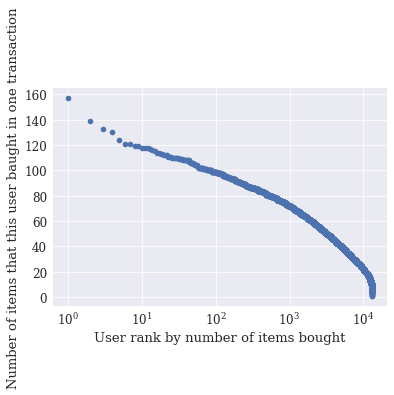

In [106]:
plt.semilogx(1 + np.arange(n_users), -np.sort(-user_activity), 'o')
plt.ylabel('Number of items that this user baught in one transaction')
plt.xlabel('User rank by number of items bought')
pass

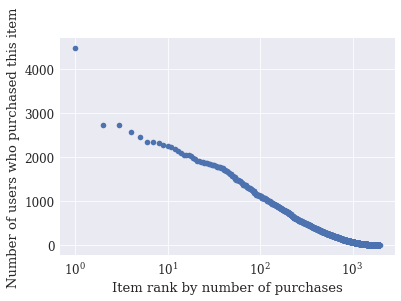

In [107]:
plt.semilogx(1 + np.arange(n_items), -np.sort(-purchase_per_item), 'o')
plt.ylabel('Number of users who purchased this item')
plt.xlabel('Item rank by number of purchases')
pass

### Generate co-occurrence matrix based on items bought in single transaction

In [112]:
OP_DIR = '/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/data/pro/Masking/Trans_Based'

In [113]:
def _coord_batch(lo, hi, train_data):
    rows = []
    cols = []
    for u in range(lo, hi):
        for w, c in itertools.permutations(train_data[u].nonzero()[1], 2):
            rows.append(w)
            cols.append(c)
    np.save(os.path.join(OP_DIR, 'coo_%d_%d.npy' % (lo, hi)),
            np.concatenate([np.array(rows)[:, None], np.array(cols)[:, None]], axis=1))
    pass

In [114]:
from joblib import Parallel, delayed

batch_size = 5000

start_idx = range(0, n_userstamp, batch_size)
end_idx = list(start_idx[1:]) + [n_userstamp]

Parallel(n_jobs=8)(delayed(_coord_batch)(lo, hi, co_train_data) for lo, hi in zip(start_idx, end_idx))
pass

In [111]:
X = sparse.csr_matrix((n_items, n_items), dtype='float32')

for lo, hi in zip(start_idx, end_idx):
    coords = np.load(os.path.join(OP_DIR, 'coo_%d_%d.npy' % (lo, hi)))
    
    rows = coords[:, 0]
    cols = coords[:, 1]
    
    tmp = sparse.coo_matrix((np.ones_like(rows), (rows, cols)), shape=(n_items, n_items), dtype='float32').tocsr()
    X = X + tmp
    
    print("User %d to %d finished" % (lo, hi))
    sys.stdout.flush()

User 0 to 5000 finished
User 5000 to 10000 finished
User 10000 to 15000 finished
User 15000 to 20000 finished
User 20000 to 25000 finished
User 25000 to 30000 finished
User 30000 to 35000 finished
User 35000 to 40000 finished
User 40000 to 45000 finished
User 45000 to 50000 finished
User 50000 to 55000 finished
User 55000 to 60000 finished
User 60000 to 65000 finished
User 65000 to 70000 finished
User 70000 to 75000 finished
User 75000 to 80000 finished
User 80000 to 85000 finished
User 85000 to 90000 finished
User 90000 to 95000 finished
User 95000 to 100000 finished
User 100000 to 105000 finished
User 105000 to 110000 finished
User 110000 to 115000 finished
User 115000 to 120000 finished
User 120000 to 125000 finished
User 125000 to 130000 finished
User 130000 to 135000 finished
User 135000 to 140000 finished
User 140000 to 145000 finished
User 145000 to 150000 finished
User 150000 to 155000 finished
User 155000 to 160000 finished
User 160000 to 165000 finished
User 165000 to 170000 

Note: Don't forget to delete all the temporary coo_LO_HI.npy files

In [115]:
np.save(os.path.join(OP_DIR, 'coordinate_trans_co_binary_data.npy'), X.data)
np.save(os.path.join(OP_DIR, 'coordinate_trans_co_binary_indices.npy'), X.indices)
np.save(os.path.join(OP_DIR, 'coordinate_trans_co_binary_indptr.npy'), X.indptr)

In [116]:
1-float(X.nnz) / np.prod(X.shape)

0.8862811562544632

### Or load the pre-saved co-occurrence matrix

In [1009]:
# or co-occurrence matrix from the entire user history
dir_predix = OP_DIR

In [194]:
data = np.load(os.path.join(dir_predix, 'coordinate_trans_co_binary_data.npy'))
indices = np.load(os.path.join(dir_predix, 'coordinate_trans_co_binary_indices.npy'))
indptr = np.load(os.path.join(dir_predix, 'coordinate_trans_co_binary_indptr.npy'))

In [195]:
X = sparse.csr_matrix((data, indices, indptr), shape=(n_items, n_items))

In [117]:
print(X.shape)

(1957, 1957)


In [118]:
1-float(X.nnz) / np.prod(X.shape)

0.8862811562544632

In [119]:
def get_row(Y, i):
    lo, hi = Y.indptr[i], Y.indptr[i + 1]
    return lo, hi, Y.data[lo:hi], Y.indices[lo:hi]

In [120]:
count = np.asarray(X.sum(axis=1)).ravel()

In [121]:
count

array([2401., 4452., 2471., ...,   18.,   11., 1312.], dtype=float32)

In [122]:
n_pairs = X.data.sum()

In [123]:
n_pairs

1071298.0

### Construct the SPPMI matrix

In [124]:
M = X.copy()

for i in range(n_items):
    lo, hi, d, idx = get_row(M, i)
    M.data[lo:hi] = np.log(d * n_pairs / (count[i] * count[idx]))

In [125]:
M.data[M.data < 0] = 0
M.eliminate_zeros()

In [126]:
1-float(M.nnz) / np.prod(M.shape)

0.9142389164690305

Now $M$ is the PPMI matrix. Depending on the number of negative examples $k$, we can obtain the shifted PPMI matrix as $\max(M_{wc} - \log k, 0)$

In [127]:
# number of negative samples
k_ns = 1

M_ns = M.copy()

if k_ns > 1:
    offset = np.log(k_ns)
else:
    offset = 0.
    
M_ns.data -= offset
M_ns.data[M_ns.data < 0] = 0
M_ns.eliminate_zeros()

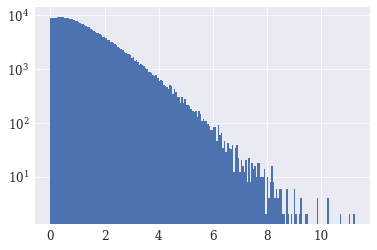

In [128]:
plt.hist(M_ns.data, bins=200)
plt.yscale('log')
pass

In [129]:
1-float(M_ns.nnz) / np.prod(M_ns.shape)

0.9142389164690305

In [130]:
M_ns.A

array([[0.        , 0.26458162, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.26458162, 0.        , 0.504108  , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.504108  , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

### Train the model

In [131]:
scale = 0.03

n_components = 100
max_iter = 20
n_jobs = 8
lam_theta = lam_beta = 1e-5 * scale
lam_gamma = 1e-5
c0 = 1. * scale
c1 = 10. * scale

save_dir = os.path.join(OP_DIR, 'ML20M_ns%d_scale%1.2E' % (k_ns, scale))

In [132]:
import cofacto
coder = cofacto.CoFacto(n_components=n_components, max_iter=max_iter, batch_size=1000, init_std=0.01, n_jobs=n_jobs, 
                        random_state=98765, save_params=True, save_dir=save_dir, early_stopping=True, verbose=True, 
                        lam_theta=lam_theta, lam_beta=lam_beta, lam_gamma=lam_gamma, c0=c0, c1=c1)

In [212]:
print(train_data)

  (0, 377)	1
  (1, 1180)	1
  (1, 1187)	1
  (1, 1277)	1
  (2, 1303)	1
  (2, 1305)	1
  (3, 1243)	1
  (3, 1501)	1
  (4, 143)	1
  (4, 1298)	1
  (5, 247)	1
  (6, 113)	1
  (6, 130)	1
  (6, 460)	1
  (6, 507)	1
  (6, 1072)	1
  (7, 1336)	1
  (9, 126)	1
  (9, 1383)	1
  (10, 1258)	1
  (10, 1274)	2
  (11, 4)	1
  (11, 69)	1
  (11, 215)	1
  (11, 699)	1
  :	:
  (502172, 160)	1
  (502173, 108)	1
  (502173, 263)	2
  (502173, 1072)	1
  (502173, 1381)	1
  (502174, 1137)	1
  (502175, 25)	1
  (502175, 39)	1
  (502175, 140)	1
  (502175, 1499)	1
  (502176, 108)	1
  (502176, 203)	1
  (502177, 957)	1
  (502177, 1273)	1
  (502177, 1790)	1
  (502177, 1874)	1
  (502179, 1399)	1
  (502180, 1159)	2
  (502180, 1271)	1
  (502180, 1352)	1
  (502181, 1139)	1
  (502182, 195)	2
  (502182, 298)	1
  (502183, 337)	1
  (502185, 1290)	1


In [133]:
np.savetxt('/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/data/pro/Trans_Based/trans_coo_mat.csv',M_ns.A)

In [134]:
coder.fit(train_data, M_ns, vad_data=vad_data, batch_users=5000, k=100)

ITERATION #0
	Updating user factors: time=0.76
	Updating item factors: time=0.41
	Updating context factors: time=0.32
	Updating bias terms: time=0.22


/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/code/rec_eval.py:257: RuntimeWarning: invalid value encountered in true_divide
  return DCG / IDCG


	Validation NDCG@k: 0.05907
ITERATION #1
	Updating user factors: time=0.67
	Updating item factors: time=0.43
	Updating context factors: time=0.28
	Updating bias terms: time=0.19
	Validation NDCG@k: 0.08415
ITERATION #2
	Updating user factors: time=0.49
	Updating item factors: time=0.36
	Updating context factors: time=0.24
	Updating bias terms: time=0.20
	Validation NDCG@k: 0.10273
ITERATION #3
	Updating user factors: time=0.49
	Updating item factors: time=0.36
	Updating context factors: time=0.24
	Updating bias terms: time=0.20
	Validation NDCG@k: 0.10765
ITERATION #4
	Updating user factors: time=0.50
	Updating item factors: time=0.37
	Updating context factors: time=0.24
	Updating bias terms: time=0.18
	Validation NDCG@k: 0.11091
ITERATION #5
	Updating user factors: time=0.52
	Updating item factors: time=0.36
	Updating context factors: time=0.24
	Updating bias terms: time=0.22
	Validation NDCG@k: 0.11318
ITERATION #6
	Updating user factors: time=0.53
	Updating item factors: time=0.42
	

CoFacto(batch_size=1000, dtype='float32', early_stopping=True, init_std=0.01,
    max_iter=20, n_components=100, n_jobs=8, random_state=98765,
    save_dir='/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/data/pro/Masking/Trans_Based/ML20M_ns1_scale3.00E-02',
    save_params=True, verbose=True)

In [135]:
test_data

<13107x1957 sparse matrix of type '<class 'numpy.int16'>'
	with 91244 stored elements in Compressed Sparse Row format>

In [136]:
n_params = len(glob.glob(os.path.join(save_dir, '*.npz')))

params = np.load(os.path.join(save_dir, 'CoFacto_K%d_iter%d.npz' % (n_components, n_params - 1)))
U, V = params['U'], params['V']

In [137]:
U.shape

(13107, 100)

In [138]:
V.shape

(1957, 100)

In [139]:
print('Test Recall@20: %.4f' % rec_eval.recall_at_k(train_data, test_data, U, V, k=20, vad_data=vad_data))
print('Test Recall@50: %.4f' % rec_eval.recall_at_k(train_data, test_data, U, V, k=50, vad_data=vad_data))
print('Test NDCG@100: %.4f' % rec_eval.normalized_dcg_at_k(train_data, test_data, U, V, k=100, vad_data=vad_data))
print('Test MAP@100: %.4f' % rec_eval.map_at_k(train_data, test_data, U, V, k=100, vad_data=vad_data))

/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/code/rec_eval.py:184: RuntimeWarning: invalid value encountered in true_divide
  recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))


Test Recall@20: 0.1104
Test Recall@50: 0.1993


/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/code/rec_eval.py:257: RuntimeWarning: invalid value encountered in true_divide
  return DCG / IDCG


Test NDCG@100: 0.1474
Test MAP@100: 0.0412


In [140]:
np.savez('CoFactor_K100_ML20M.npz', U=U, V=V)

In [141]:
R=U.dot(V.T)

In [142]:
R.shape

(13107, 1957)

In [143]:
R.min()

-11.360427

In [144]:
R.max()

78.05599

In [145]:
train_data.shape

(13107, 1957)

In [146]:
seg2id = dict((sid, i) for (i, sid) in enumerate(unique_sid)) 
user2id = dict((uid, i) for (i, uid) in enumerate(unique_uid))

In [147]:
id2seg = dict((i, sid) for (i, sid) in enumerate(unique_sid))
id2user = dict((i, uid) for (i, uid) in enumerate(unique_uid))

In [148]:
V

array([[-0.00298898,  0.06655665, -0.02699008, ..., -0.0031352 ,
        -0.07972001,  0.02685754],
       [ 0.13012509, -0.04814968, -0.05750973, ...,  0.01546583,
        -0.05087804,  0.04638054],
       [ 0.11194933,  0.00803433,  0.04769098, ...,  0.0407963 ,
        -0.065392  , -0.0424267 ],
       ...,
       [-0.0157846 ,  0.00864747,  0.02757657, ...,  0.01886795,
         0.0334826 , -0.02045046],
       [-0.01894267,  0.00695286,  0.02791657, ...,  0.0198131 ,
         0.03249795, -0.0217262 ],
       [-0.0202565 ,  0.08502637,  0.12248929, ...,  0.03571663,
        -0.04030122, -0.00626752]], dtype=float32)

In [149]:
from sklearn.preprocessing import MinMaxScaler  

In [150]:

#------------------------------
# CREATE USER RECOMMENDATIONS
#------------------------------
def recommend(original_user_id, data_sparse, user_vecs, item_vecs, user2id, seg2id, id2user, id2seg, num_items=10):
    """Recommend items for a given user given a trained model

    Args:
    user_id (int): The id of the user we want to create recommendations for.

    data_sparse (csr_matrix): Our original training data.

    user_vecs (csr_matrix): The trained user x features vectors

    item_vecs (csr_matrix): The trained item x features vectors

    id2seg (dictionary): Used to map ids to segment names

    num_items (int): How many recommendations we want to return:

    Returns:
    recommendations (pandas.DataFrame): DataFrame with num_items artist names and scores

    """
    user_id = user2id[str(original_user_id)]
    # Get all interactions by the user
    user_interactions = data_sparse[user_id,:].toarray()
 
    # We don't want to recommend items the user has consumed. So let's
    # set them all to 0 and the unknowns to 1.
    user_interactions = user_interactions.reshape(-1) + 1 #Reshape to turn into 1D array
    user_interactions[user_interactions > 1] = 0
 
    # This is where we calculate the recommendation by taking the
    # dot-product of the user vectors with the item vectors.
    rec_vector = user_vecs[user_id,:].dot(item_vecs.T)
 
    # Let's scale our scores between 0 and 1 to make it all easier to interpret.
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    recommend_vector = rec_vector_scaled
 
    # Get all the segments indices in order of recommendations (descending) and
    # select only the top "num_items" items.
    item_idx = np.argsort(recommend_vector)[::-1][:num_items]
 
    top_n_recommended_items = []
    item_scores = []
 
    # Loop through our recommended segments indicies and look up the actial artist name
    top_n_recommended_items = list(map(lambda x: id2seg[x], item_idx))
    top_n_recommended_items
 

    for item_id in item_idx:
        item_scores.append(recommend_vector[item_id])
 
    # Create a new dataframe with recommended artist names and scores
    recommendations = pd.DataFrame({'items': top_n_recommended_items, 'score': item_scores})
 
    return recommendations.sort_values(['score'], ascending=[False])
 



In [151]:
recommendations = recommend(15,train_data,U,V,user2id,seg2id,id2user,id2seg,15)
recommendations

,items,score
0,4-58-12-54,1.000000
1,3-86-1-3,0.994309
2,7-4-1-5,0.982526
3,1-11-3-2,0.977919
4,2-13-4-28,0.926691
5,5-41-41-43,0.881253
6,7-71-6-2,0.877460
7,4-56-5-32,0.855463
8,7-16-10-11,0.841000
9,5-41-90-90,0.823902


In [152]:
user2id['15']

2

In [153]:
items=test_data.A[2].nonzero()

In [154]:
print(items)

(array([  28,  573,  742, 1709, 1772, 1856, 1922]),)


In [155]:
test_i=np.array(list((map(lambda x: id2seg[x], np.array(items[0])))))

In [156]:
print(test_i.reshape(-1,1))

[['1-11-3-27']
 ['2-80-5-29']
 ['3-26-12-22']
 ['7-14-64-78']
 ['7-4-1-55']
 ['7-78-6-46']
 ['7-9-20-21']]


In [157]:
recommendations

,items,score
0,4-58-12-54,1.000000
1,3-86-1-3,0.994309
2,7-4-1-5,0.982526
3,1-11-3-2,0.977919
4,2-13-4-28,0.926691
5,5-41-41-43,0.881253
6,7-71-6-2,0.877460
7,4-56-5-32,0.855463
8,7-16-10-11,0.841000
9,5-41-90-90,0.823902


In [158]:
#------------------------------
# FIND SIMILAR ITEMS
#------------------------------
def get_similar_items(item_id, number_of_similar_items, U, V, id2user, id2seg):
    item_vecs = V
 
    item_id = item_id
 
    # Get the item row for item_id
    item_vec = item_vecs[item_id].T
 
    n = number_of_similar_items
    # Calculate the similarity score between item_id  and other items
    # and select the top n most similar.
    scores = item_vecs.dot(item_vec).reshape(1,-1)[0]
    top_10 = np.argsort(scores)[::-1][:n]
 
    items = []
    item_scores = []
 
    top_10_similar_items = list(map(lambda x: id2seg[x], top_10))
    top_10_similar_items
 
    for item_id in top_10:
        item_scores.append(scores[item_id])
 
    similar = pd.DataFrame({'items': top_10_similar_items, 'item_score': item_scores})
 
    return similar

In [159]:
items_similar_to_id_1 = get_similar_items(1,15,U,V,id2user,id2seg)

In [160]:
items_similar_to_id_1

,items,item_score
0,1-1-13-13,0.431870
1,1-2-2-40,0.408735
2,7-71-6-2,0.370305
3,7-9-19-32,0.370285
4,1-6-6-6,0.361960
5,3-36-12-13,0.360948
6,7-4-16-45,0.360695
7,1-3-22-3,0.350927
8,7-71-6-6,0.348998
9,7-4-1-5,0.346140


In [161]:
#------------------------------
# GET ITEMS CONSUMED BY USER
#------------------------------
def seg_purchased_by_user(original_user_id, train_data, U, V, user2id, seg2id, id2user, id2seg):
    user_id = user2id[str(original_user_id)]
    # Let's print out what the user has purchased to
    purchased_seg_idx = train_data[user_id,:].nonzero()[1].astype(str)
    purchased_segments = list(map(lambda x: id2seg[int(x)], purchased_seg_idx))
    return purchased_segments

In [162]:
seg_purchased = seg_purchased_by_user(15,train_data,U,V,user2id,seg2id,id2user,id2seg)

In [163]:
seg_purchased

['1-1-8-6',
 '1-11-3-2',
 '1-3-16-19',
 '1-3-4-53',
 '1-46-20-20',
 '2-10-50-31',
 '2-10-51-58',
 '2-10-54-59',
 '2-13-1-1',
 '2-13-4-28',
 '3-36-12-13',
 '4-35-2-18',
 '4-58-15-59',
 '5-41-90-90',
 '7-16-10-11',
 '7-4-1-5',
 '7-4-9-9',
 '7-71-6-2',
 '7-78-6-45']

In [164]:
R_copy=R.copy()

In [1058]:
min_max = MinMaxScaler()
R1 = min_max.fit_transform(R.reshape(-1,1))[:,0]

In [1059]:
R1=R1.reshape(R.shape)

In [168]:
R1

In [169]:
R1.min()

-11.360427

In [170]:
R1.max()

78.05599

(array([   6544.,    7101.,    7530.,    8037.,    8718.,    9257.,
           9771.,   10360.,   11395.,   12103.,   12644.,   13976.,
          14803.,   15903.,   17188.,   18124.,   19842.,   21105.,
          22998.,   24516.,   26978.,   28980.,   31432.,   33705.,
          36797.,   39872.,   43658.,   47475.,   52048.,   56923.,
          61813.,   68074.,   74628.,   82181.,   90998.,  101146.,
         112343.,  125604.,  140948.,  159187.,  182008.,  209811.,
         245314.,  292319.,  356156.,  454021.,  613656.,  915623.,
        1552859., 3013822., 3573472., 2025422., 1446554., 1085336.,
         851795.,  697427.,  584610.,  500399.,  436184.,  383209.,
         340036.,  304093.,  273599.,  247118.,  224767.,  205368.,
         186841.,  171460.,  157256.,  144427.,  133819.,  123355.,
         114234.,  106221.,   98395.,   91911.,   85008.,   79063.,
          74218.,   68990.,   65071.,   60686.,   57028.,   53604.,
          50366.,   47449.,   45180.,   42302., 

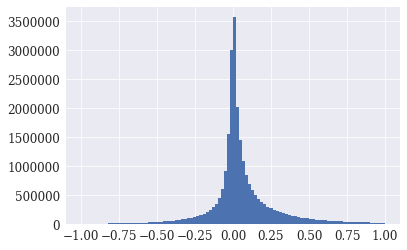

In [208]:
matplotlib.pyplot.hist(R1.ravel(),bins=100,range=(-1,1))

In [173]:
def create_pred_array(i,j):
    return R1[i,j]

In [174]:
def create_test_array(i,j):
    return test_data[i,j] 

In [175]:
test_array_final = Parallel(n_jobs=8)(delayed(create_test_array) (i,j) for i, j in samples)
pred_array_final = Parallel(n_jobs=8)(delayed(create_pred_array) (i,j) for i, j in samples)

In [176]:
test_array_final

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [177]:
min(pred_array_final)

-8.10039

In [178]:
max(pred_array_final)

28.098295

In [179]:
testing_data=sparse.csr_matrix((10,10),dtype=np.int16)

In [180]:
testing_data.A

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int16)

In [181]:
testing_r=sparse.csr_matrix((10,10),dtype=np.int16)

In [182]:
testing_r[:]=np.random.randint(10,size=(10,10))

/Users/hr250012/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  """Entry point for launching an IPython kernel.


In [183]:
testing_r

<10x10 sparse matrix of type '<class 'numpy.int16'>'
	with 100 stored elements in Compressed Sparse Row format>

In [184]:
testing_r.A

array([[7, 8, 0, 2, 6, 3, 8, 8, 6, 7],
       [4, 5, 5, 7, 3, 2, 1, 2, 6, 7],
       [0, 3, 0, 2, 5, 9, 8, 7, 6, 1],
       [7, 2, 4, 9, 4, 5, 0, 8, 6, 6],
       [4, 2, 2, 2, 6, 2, 6, 8, 7, 1],
       [0, 8, 8, 3, 6, 6, 0, 5, 0, 5],
       [3, 5, 1, 5, 9, 0, 0, 5, 2, 9],
       [2, 8, 6, 1, 3, 4, 4, 3, 2, 1],
       [1, 4, 8, 6, 7, 1, 0, 2, 1, 3],
       [9, 1, 1, 9, 0, 7, 6, 7, 7, 9]], dtype=int16)

In [185]:
a=np.squeeze(np.asarray(testing_data[np.nonzero(testing_data == 0)]))

/Users/hr250012/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [186]:
len(a)

100

In [187]:
a

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int16)

In [188]:
b=testing_r[np.nonzero(testing_data == 0)]

In [189]:
b

matrix([[7, 8, 0, 2, 6, 3, 8, 8, 6, 7, 4, 5, 5, 7, 3, 2, 1, 2, 6, 7, 0,
         3, 0, 2, 5, 9, 8, 7, 6, 1, 7, 2, 4, 9, 4, 5, 0, 8, 6, 6, 4, 2,
         2, 2, 6, 2, 6, 8, 7, 1, 0, 8, 8, 3, 6, 6, 0, 5, 0, 5, 3, 5, 1,
         5, 9, 0, 0, 5, 2, 9, 2, 8, 6, 1, 3, 4, 4, 3, 2, 1, 1, 4, 8, 6,
         7, 1, 0, 2, 1, 3, 9, 1, 1, 9, 0, 7, 6, 7, 7, 9]], dtype=int16)

In [190]:
b.shape

(1, 100)

In [191]:
test_array_final_2 = np.squeeze(np.asarray(total_data[np.nonzero(total_data == 0)]))
pred_array_final_2 = R1[np.nonzero(total_data == 0)]

In [192]:
test_array_final_2

array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

In [193]:
max(test_array_final_2)

0

In [194]:
pred_array_final_2

array([-0.40231988,  0.62053365, -0.7916933 , ..., -0.01185209,
       -0.01309409, -0.00240576], dtype=float32)

In [195]:
test_array_for_auc = np.concatenate([test_array_final,test_array_final_2])
pred_array_for_auc = np.concatenate([pred_array_final,pred_array_final_2])

In [196]:
pred_array_for_auc.min()

-11.360427

In [197]:
pred_array_for_auc.max()

28.098295

In [198]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

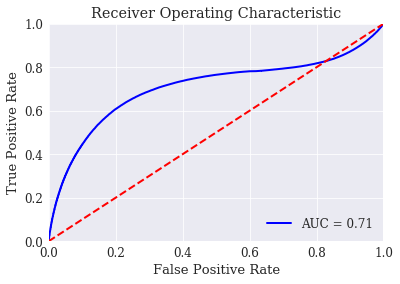

In [199]:

fpr, tpr, threshold = metrics.roc_curve(test_array_for_auc, pred_array_for_auc)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [200]:
R1 = R.copy()

(array([   6544.,    7101.,    7530.,    8037.,    8718.,    9257.,
           9771.,   10360.,   11395.,   12103.,   12644.,   13976.,
          14803.,   15903.,   17188.,   18124.,   19842.,   21105.,
          22998.,   24516.,   26978.,   28980.,   31432.,   33705.,
          36797.,   39872.,   43658.,   47475.,   52048.,   56923.,
          61813.,   68074.,   74628.,   82181.,   90998.,  101146.,
         112343.,  125604.,  140948.,  159187.,  182008.,  209811.,
         245314.,  292319.,  356156.,  454021.,  613656.,  915623.,
        1552859., 3013822., 3573472., 2025422., 1446554., 1085336.,
         851795.,  697427.,  584610.,  500399.,  436184.,  383209.,
         340036.,  304093.,  273599.,  247118.,  224767.,  205368.,
         186841.,  171460.,  157256.,  144427.,  133819.,  123355.,
         114234.,  106221.,   98395.,   91911.,   85008.,   79063.,
          74218.,   68990.,   65071.,   60686.,   57028.,   53604.,
          50366.,   47449.,   45180.,   42302., 

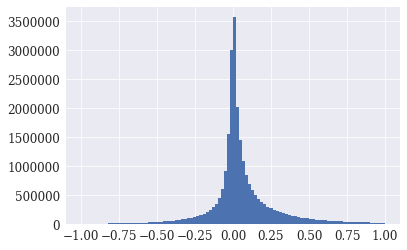

In [209]:
matplotlib.pyplot.hist(R1.ravel(),bins=100,range=(-1,1))

In [210]:
R1[R1< -1]=-1

In [211]:
R1[R1>1]=1

In [212]:
R1.min()

-1.0

In [213]:
R1.max()

1.0

(array([      0.,       0.,       0.,  127964.,    9149.,   10171.,
          11056.,   12306.,   13107.,   14489.,   15994.,   17242.,
          19273.,   21025.,   23280.,   25337.,   28155.,   31283.,
          34586.,   38754.,   43024.,   47507.,   53392.,   60098.,
          67522.,   76214.,   86018.,   97268.,  110539.,  127271.,
         146735.,  170198.,  198657.,  236818.,  286537.,  356682.,
         460302.,  636687.,  996387., 1922743., 4755833., 3322686.,
        2042272., 1387945., 1022599.,  800328.,  650523.,  542880.,
         460858.,  396457.,  345237.,  302842.,  267737.,  236950.,
         210777.,  188585.,  169979.,  152941.,  138119.,  125582.,
         113379.,  103018.,   94115.,   86509.,   78967.,   72905.,
          66854.,   62031.,   57487.,   53448.,   49488.,   46470.,
          43405.,   40158.,   36842.,   34239.,   30976.,  425208.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0., 

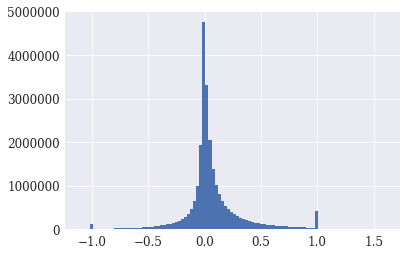

In [214]:
matplotlib.pyplot.hist(R1.ravel(),bins=100,range=(-1.1,1.6))

In [1263]:
R1=R1+1

In [1264]:
R1.max()

2.0

In [1265]:
R1=R1/2

(array([      0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,  128207.,   19578.,
          23379.,   27761.,   33602.,   40529.,   49150.,   60209.,
          74344.,   92401.,  116333.,  146577.,  188272.,  245812.,
         328257.,  455494.,  681366., 1190745., 3329245., 7654973.,
        3143685., 1778313., 1197047.,  873511.,  666736.,  522632.,
         416325.,  334911.,  274384.,  226286.,  188221.,  159392.,
         135660.,  117960.,  102157.,   87786.,   75218.,  463941.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0., 

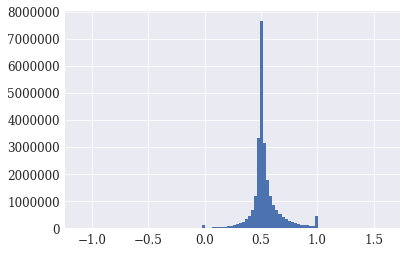

In [1266]:
matplotlib.pyplot.hist(R1.ravel(),bins=100,range=(-1.1,1.6))

In [1267]:
R1.mean()

0.5341724

In [1268]:
np.median(R1)

0.5096377

In [215]:
test_array_final = Parallel(n_jobs=8)(delayed(create_test_array) (i,j) for i, j in samples)
pred_array_final = Parallel(n_jobs=8)(delayed(create_pred_array) (i,j) for i, j in samples)

(array([  999.,    50.,    55.,    50.,    48.,    75.,    66.,    73.,
           74.,    81.,    72.,    86.,    88.,   114.,   114.,   104.,
          119.,   130.,   143.,   153.,   166.,   181.,   163.,   201.,
          199.,   211.,   245.,   233.,   276.,   333.,   277.,   334.,
          348.,   384.,   439.,   447.,   507.,   501.,   534.,   606.,
          655.,   712.,   763.,   849.,   945.,  1021.,  1125.,  1277.,
         1543.,  1717.,  2032.,  2176.,  2217.,  2174.,  2052.,  2073.,
         2052.,  1931.,  2054.,  1869.,  1809.,  1885.,  1768.,  1757.,
         1710.,  1579.,  1540.,  1468.,  1450.,  1370.,  1385.,  1271.,
         1277.,  1240.,  1179.,  1138.,  1081.,  1040.,  1041.,  1048.,
          939.,   917.,   839.,   860.,   773.,   754.,   690.,   700.,
          725.,   644.,   661.,   591.,   567.,   562.,   514.,   487.,
          492.,   484.,   456., 10037.]),
 array([-1.  , -0.98, -0.96, -0.94, -0.92, -0.9 , -0.88, -0.86, -0.84,
        -0.82, -0.8 , -

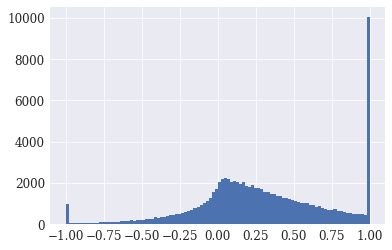

In [216]:
matplotlib.pyplot.hist(pred_array_final,bins=100)

In [217]:
len(pred_array_final)

91244

(array([ 2694.,  6585., 31237., 28036., 22692.]),
 array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ], dtype=float32),
 <a list of 5 Patch objects>)

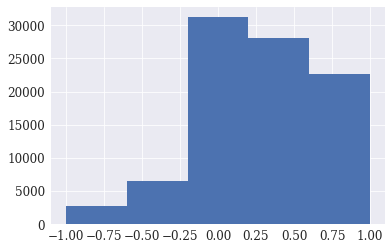

In [218]:
matplotlib.pyplot.hist(pred_array_final,bins=5)

In [220]:
len(np.array(pred_array_final)[np.array(pred_array_final) >=0.0])/len(pred_array_final)

0.7820569023716628

In [221]:
test_array_final_2 = np.squeeze(np.asarray(total_data[np.nonzero(total_data == 0)]))
pred_array_final_2 = R1[np.nonzero(total_data == 0)]

In [222]:
min(test_array_final_2)

0

In [223]:
max(test_array_final_2)

0

(array([ 130334.,    7015.,    7451.,    7958.,    8639.,    9155.,
           9675.,   10249.,   11279.,   11971.,   12531.,   13849.,
          14670.,   15737.,   17020.,   17978.,   19655.,   20907.,
          22785.,   24299.,   26724.,   28730.,   31167.,   33404.,
          36474.,   39542.,   43281.,   47134.,   51641.,   56449.,
          61367.,   67574.,   74107.,   81615.,   90347.,  100465.,
         111580.,  124852.,  140145.,  158305.,  180978.,  208739.,
         244172.,  291063.,  354716.,  452509.,  611931.,  913657.,
        1550486., 3011010., 3569947., 2021247., 1441804., 1080213.,
         846637.,  692101.,  579245.,  494957.,  430528.,  377764.,
         334419.,  298633.,  268063.,  241639.,  219200.,  199819.,
         181371.,  165934.,  151729.,  138771.,  128108.,  117713.,
         108437.,  100383.,   92557.,   85882.,   78897.,   73083.,
          67843.,   62542.,   58513.,   53998.,   50316.,   46593.,
          43342.,   40414.,   37895.,   34921., 

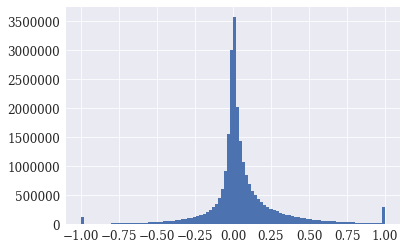

In [224]:
matplotlib.pyplot.hist(pred_array_final_2,bins=100)

In [225]:
test_array_for_auc = np.concatenate([test_array_final,test_array_final_2])
pred_array_for_auc = np.concatenate([pred_array_final,pred_array_final_2])

In [226]:
pred_array_for_auc.min()

-1.0

In [227]:
pred_array_for_auc.max()

1.0

In [228]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

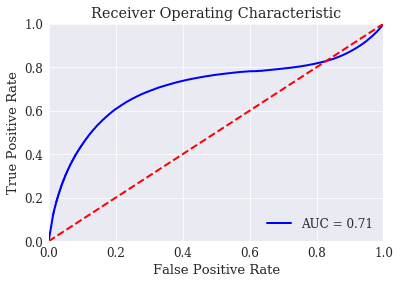

In [229]:
preds = pred_array_for_auc
fpr, tpr, threshold = metrics.roc_curve(test_array_for_auc, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [231]:
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(test_array_for_auc, preds)


In [235]:
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
 

SyntaxError: invalid character in identifier (<ipython-input-235-caab67382d16>, line 2)

In [236]:
average_precision

0.015723555135548968

In [237]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(test_array_for_auc, preds)

In [240]:
from sklearn.utils.fixes import signature
step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})


Text(0.5,1,'2-class Precision-Recall curve: AP=0.02')

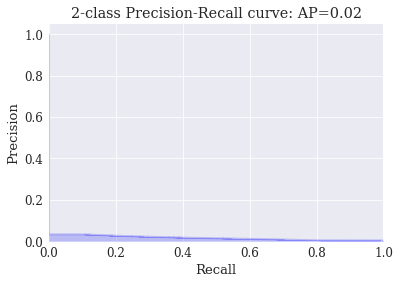

In [241]:
plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))